In [1]:
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d 
from scipy.signal import medfilt
from sklearn import linear_model as lm
from scipy import optimize

%matplotlib inline

/Users/Spencer/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


for each vortex in PWG_set:
    ImputedVortex = Impute(vortex)

In [2]:
files = glob.glob('Results/*.csv')

files_array = []
for file in files:
    files_array.append(pd.DataFrame.from_csv(file))

df = pd.concat(files_array)
df.index = range(len(df))
df.head()

,flow,volume,vortex,side_f,side_h1,PWG,meta
0,NaN,NaN,NaN,NaN,NaN,ATS24*8.0,Sidestack (Purple 2)Downstream A (Blue)Mouthpi...
1,NaN,NaN,NaN,NaN,NaN,ATS24*8.0,Sidestack (Purple 2)Downstream A (Blue)Mouthpi...
2,NaN,NaN,NaN,NaN,NaN,ATS24*8.0,Sidestack (Purple 2)Downstream A (Blue)Mouthpi...
3,NaN,NaN,NaN,NaN,NaN,ATS24*8.0,Sidestack (Purple 2)Downstream A (Blue)Mouthpi...
4,NaN,NaN,NaN,NaN,NaN,ATS24*8.0,Sidestack (Purple 2)Downstream A (Blue)Mouthpi...


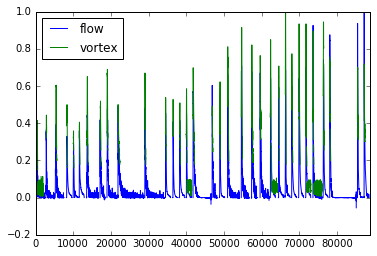

In [3]:
(df[['flow','vortex']]/df[['flow','vortex']].max()).plot()

In [4]:
df_grouped = df.groupby('meta')

6
6
10
9
2
3
3


meta
Sidestack (Purple 2)Downstream A (Blue)Mouthpiece B (Red)0% Infill (Blue)          6
Sidestack (Purple 2)Downstream D (Yellow)Mouthpiece D (Yellow)0% Infill (Blue)    10
Sidestack (Purple 2)Downstream D (Yellow)Mouthpiece E (Black)0% Infill (Blue)      9
Sidestack (Purple 4)Downstream D (Yellow)Mouthpiece D (Yellow)0% Infill (Blue)     2
Sidestack (Purple 4)Downstream D (Yellow)Mouthpiece E (Black)0% Infill (Blue)      3
Sidestack (Purple 8)Downstream D (Yellow)Mouthpiece D (Yellow)0% Infill (Blue)     3
dtype: int64

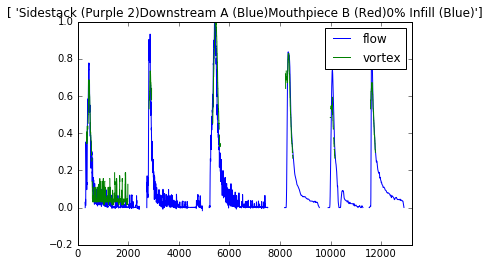

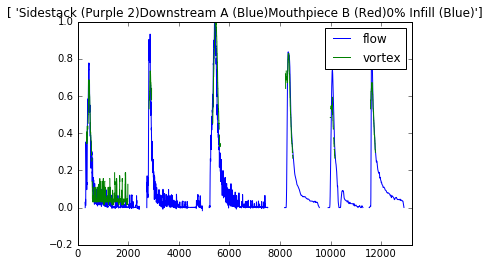

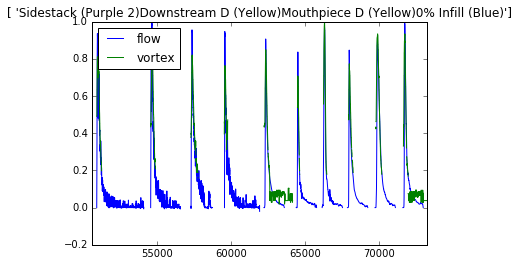

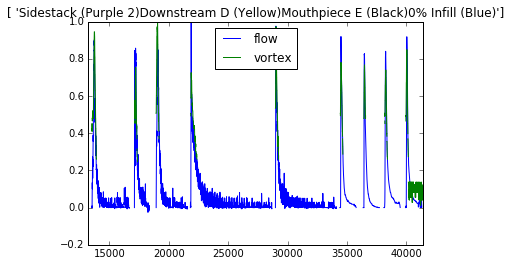

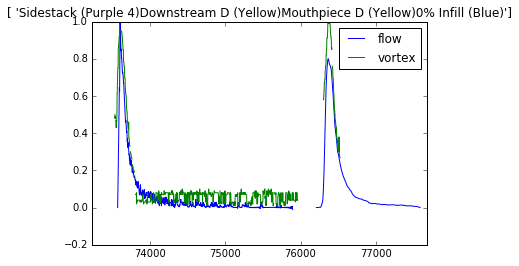

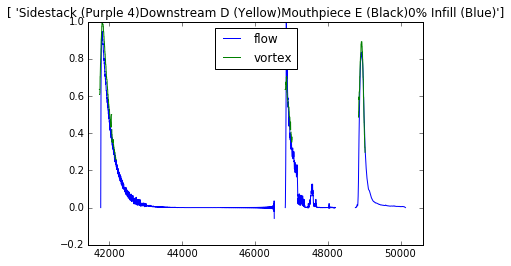

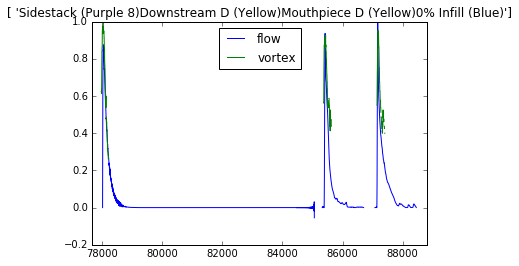

In [5]:
def analyze_groups(grp):
    print len(grp['PWG'].unique())
    plt.figure()
    (grp[['flow','vortex']]/grp[['flow','vortex']].max()).plot()
    plt.title(grp.meta.unique())
    return len(grp['PWG'].unique())
    
df_result = df_grouped.apply(analyze_groups)
df_result

In [6]:
def linear_mix( start, end ):
    mix = np.linspace(1, 0, len(start))
    return mix * start + (1 - mix) * end

# We use no offset, e.g. we asymptotically approach zero
def exponential_tail(x, a0, a1, b0, b1):
    return a0 * np.exp(-b0*x) + a1 * np.exp(-b1*x*x)

def expexp_tail(x, a0, b0):
    return a0 * np.exp(np.exp(-b0*x))

def make_p0(tail_model, a, b):
    if tail_model == exponential_tail:
        return [a, a, b, b]
    if tail_model == expexp_tail:
        return [a, b]
    return None

# Given a signal x, with tail x[start_idx:end_idx], fit the funciton tail_model
# (which should be exponential_tail, or expexp_tail) to the tail, and modify x
# such that it decays according to tail_model.  Return x
def fit_tail( tail_model, x, start_idx, end_idx, mixfunc=linear_mix ):
    x = np.copy(x)
    x_tail = x[start_idx:end_idx+(end_idx-start_idx)/10]
    a = x_tail[0]
    b = 0.01
    
    nans = np.isnan(x_tail)
    xx = np.array(range(len(x_tail)))
    popt, pcov = optimize.curve_fit(tail_model, xx[~nans], x_tail[~nans], p0=make_p0(tail_model, a, b))

    
    gen_tail = exponential_tail(np.arange(len(x) - start_idx), *popt)
    x_tail[nans] = gen_tail[nans]
    x[start_idx:end_idx+(end_idx-start_idx)/10] = x_tail
    x[start_idx:end_idx] = mixfunc(x[start_idx:end_idx], gen_tail[:end_idx-start_idx])
    x[end_idx:] = gen_tail[end_idx-start_idx:]
    return x


def fit_head(y, peak_idx, first_finite):
    # Create a copy of x so the original isn't modified
    y = np.copy(y)
    # Shift peak_idx so the first slope is actually steep
#     peak_idx = np.copy(peak_idx) - 10
    
    # Define slope window
    window = 30
    start_idx = int(0.25 * (peak_idx - first_finite))
    for i in range(start_idx, 0, -1):
        start_slope = np.nanmean(np.diff(y[peak_idx - i - window : peak_idx - i + 1]))
        if start_slope > 0:
#             print i, start_slope
            peak_idx = peak_idx - i
            break
        
    init_start_slope = np.nanmean(np.diff(y[peak_idx - 10 : peak_idx + 1]))
    if start_slope <= 0 or init_start_slope > start_slope:
        start_slope = init_start_slope
        
    
#     print start_slope, '@', peak_idx - window, ':', peak_idx
    
    last_valid = peak_idx - 1
    
    # Iterate backwards from peak to find last valuable slope
    for i in range(peak_idx - 1, 0, -1):
        # Get new window
        ytmp = y[i - window : i + 1]
#         print start_slope, '@', i - window, ':', i
        # If any values in the window are NaN, we've gone too far... break
        if np.isnan(ytmp).any():
#             print 'Breaking at', i, ' because NaN was found'
            last_valid = i
            break
        
        # Get new slope
        slope =  np.nanmean(np.diff(ytmp))
        
        # Compare new slope against last slope. If diff is > th %, break and use last slope value
        th = -.1
#         if np.abs(slope-start_slope)/float(start_slope)>th:
        if slope - start_slope < th or slope <= 0:
#             print 'Breaking at', i, ' because slope diff exceeded thresh', slope, start_slope
            last_valid = i
            break    
        elif slope > start_slope:
#         else:
            start_slope = slope
    
    # Calc. the width required for the curve to reach 0 from peak
    
    front_width = int(np.ceil(y[last_valid]/start_slope))

    # Check to see if peak_idx - start_width occurs before the beginning of x
    num_zeros_added = 0
    if last_valid - front_width < 0:
        num_zeros_added = front_width - last_valid
        # push difference worth of zeros onto front
        y = np.hstack((np.zeros(front_width - last_valid), y))
        # move peak_idx to updated location
        last_valid += front_width - last_valid

    # From where the curve should be 0 (which may be at x[0] or later), replace values with
    # ... values from approximated slope curve
#     print front_width
    y[last_valid - front_width : last_valid + 1] = np.linspace(0, y[last_valid], front_width + 1)

    # Zero out everything before as well
    y[ : last_valid - front_width] = 0
    return y, num_zeros_added

In [7]:
def nan_interp(y):
    y = np.copy(y)
    y[0]=0.0
    y[1]=0.0
    y[-1] = 0.0
    y[-2] = 0.0
    x = np.array(range(len(y)))
    peak_idx = np.nanargmax(y)
    peak = np.nanmax(y)
    
    nans = np.isnan(y)
    
    first_finite = 0
    last_finite = len(nans) - 1
    
    for i in range(2, len(nans)):
        if nans[i] == False:
            first_finite = i
            break
    
    for i in range(len(nans) - 3, 0, -1):
        if nans[i] == False:
            last_finite = i
            break
            
#     print first_finite, last_finite
    
    # MID
    x_mid = x[first_finite + 1 : last_finite]
    y_mid = y[first_finite + 1 : last_finite]
    nans_mid = nans[first_finite + 1 : last_finite]
    
    f_mid = interp1d(x_mid[~nans_mid], y_mid[~nans_mid], kind = 1)
    y_mid[nans_mid] = f_mid(x_mid[nans_mid])
    
    # Replace y (at mid) with the new interpolated y_mid values
    y[first_finite + 1 : last_finite] = y_mid
    
    
    # FRONT
    y, zeros_added = fit_head(y, peak_idx, first_finite)
    
    
    # BACK
    y = fit_tail(exponential_tail, np.copy(y), peak_idx, len(y))

    return y, zeros_added

In [8]:
# def impute_vortex(PWG):
#     y = np.copy(df[df.PWG==PWG]['vortex'].values)
#     flow = np.copy(df[df.PWG==PWG]['flow'].values)
#     return nan_interp(np.copy(y))

In [9]:
i = 0

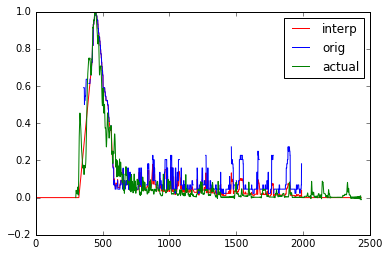

In [10]:

PWG = df.PWG[5000*i]
y = np.copy(df[df.PWG==PWG]['vortex'].values)
flow = np.copy(df[df.PWG==PWG]['flow'].values)

ynew,_ = nan_interp(np.copy(y))

plt.plot(ynew/ynew.max(),'r',label='interp')
plt.plot(y/np.nanmax(y), label='orig')
plt.plot(flow/np.nanmax(flow), 'g', label='actual')
plt.legend()
i = i+1

In [11]:
df['imputed_vortex'] = np.ones(df.vortex.shape)
pwgs = df.PWG.unique()
for PWG in pwgs:
    y = np.copy(df[df.PWG==PWG]['vortex'].values)
    flow = np.copy(df[df.PWG==PWG]['flow'].values)
    y, addzeros = nan_interp(np.copy(y))
    y = y[addzeros:]
    df.imputed_vortex[df.PWG==PWG] = y
    

/Users/Spencer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


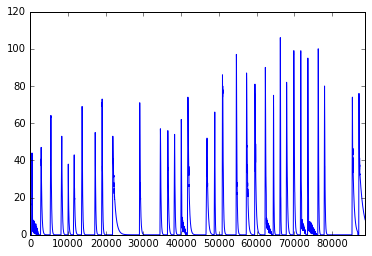

In [12]:
df.imputed_vortex.plot()

6
6
10
9
2
3
3


meta
Sidestack (Purple 2)Downstream A (Blue)Mouthpiece B (Red)0% Infill (Blue)          6
Sidestack (Purple 2)Downstream D (Yellow)Mouthpiece D (Yellow)0% Infill (Blue)    10
Sidestack (Purple 2)Downstream D (Yellow)Mouthpiece E (Black)0% Infill (Blue)      9
Sidestack (Purple 4)Downstream D (Yellow)Mouthpiece D (Yellow)0% Infill (Blue)     2
Sidestack (Purple 4)Downstream D (Yellow)Mouthpiece E (Black)0% Infill (Blue)      3
Sidestack (Purple 8)Downstream D (Yellow)Mouthpiece D (Yellow)0% Infill (Blue)     3
dtype: int64

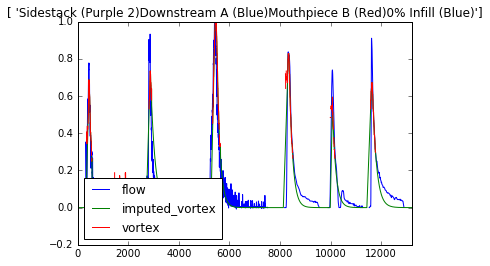

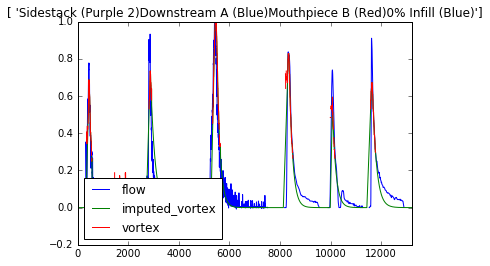

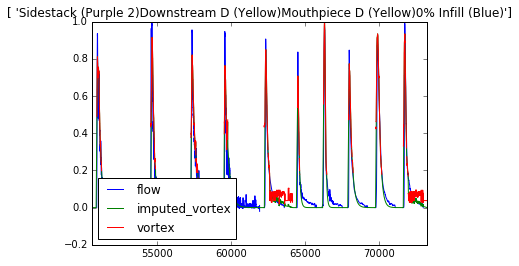

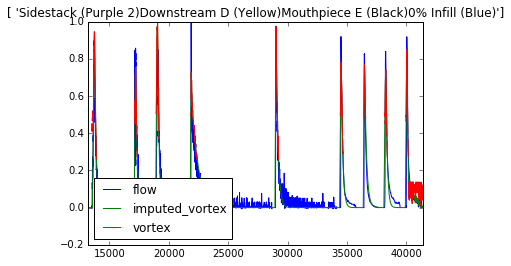

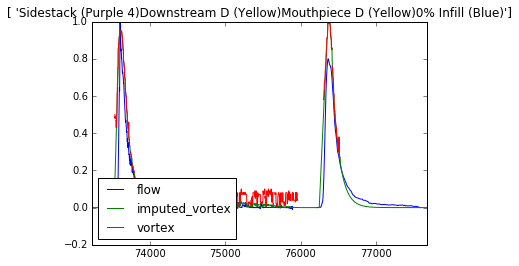

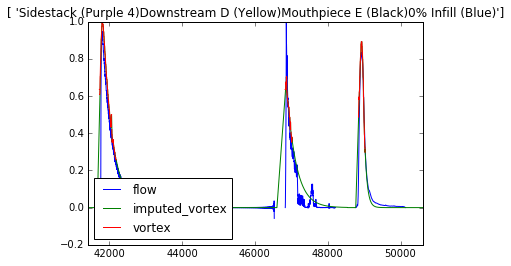

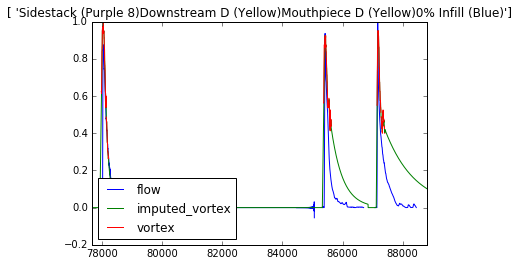

In [13]:
def analyze_groups(grp):
    print len(grp['PWG'].unique())
    plt.figure()
    (grp[['flow','imputed_vortex', 'vortex']]/grp[['flow','imputed_vortex', 'vortex']].max()).plot()
    plt.title(grp.meta.unique())
    plt.legend(loc=3)
    return len(grp['PWG'].unique())

df_grouped = df.groupby('meta')
df_result = df_grouped.apply(analyze_groups)
df_result

In [61]:
df['flow_pred'] = np.zeros(df.flow.shape)
df.flow[df.flow<0]=0
df.flow[np.isnan(df.flow)]=0
df.side_f[np.isnan(df.side_f)]=0
df.side_h1[np.isnan(df.side_h1)]=0
for grp_whistle in df['meta'].unique():
    grp = df[df.meta==grp_whistle]

    for grp_pwg in grp['PWG'].unique():
        df_test = grp[grp['PWG']==grp_pwg]
        df_train = grp[grp['PWG']!=grp_pwg]

#         feature_names = ['imputed_vortex']        
        feature_names = ['imputed_vortex','side_f','side_h1']
        
        X = df_train[feature_names].values
        y = df_train.flow.values
        y[np.isnan(y)] = 0
#         idx = y>0.1
#         y=y[idx]
#         X=X[idx]
        
        Xtest = df_test[feature_names].values
        ytest = df_test.flow.values
        ytest[np.isnan(ytest)] = 0
        
        reg = lm.Ridge()
        yhat = reg.fit(X,y).predict(Xtest)
        yhat[yhat<0]=0
        
        df.flow_pred[(df.meta==grp_whistle)&(df['PWG']==grp_pwg)] = yhat
    
    


/Users/Spencer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Spencer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/Spencer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Spencer/anaconda/lib/python2.7/site-packages/ipyker

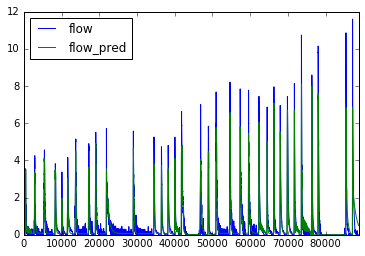

In [62]:
df[['flow','flow_pred']].plot()

{'boxes': [<matplotlib.lines.Line2D at 0x1223b7ad0>],
 'caps': [<matplotlib.lines.Line2D at 0x11ffa3e90>,
 'fliers': [<matplotlib.lines.Line2D at 0x121f16f10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x121f0e410>],
 'whiskers': [<matplotlib.lines.Line2D at 0x11ffad210>,
  <matplotlib.lines.Line2D at 0x11ffada10>]}

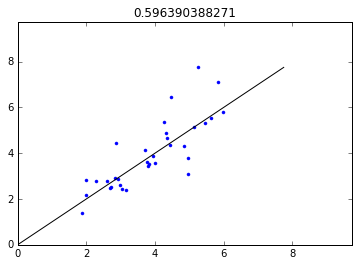

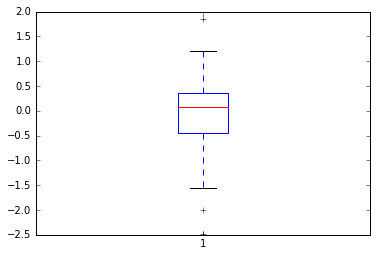

In [63]:
fs_effective = float(44100)/128.0
def calc_fvc(f):
    v = np.cumsum(f/fs_effective)
    return np.max(v)

def pd_fvc(grp):
    v1 = calc_fvc(grp['flow'])
    v2 = calc_fvc(medfilt(grp['flow_pred'].values,kernel_size=51))
    return pd.DataFrame(np.array([v1,v2]).reshape((1,2)),columns=['fvc','fvc_pred'])

df_pwg = df.groupby('PWG')
tmp = df_pwg.apply(pd_fvc)
tmp['fvc_pred']= tmp['fvc_pred']
plt.plot(tmp['fvc'],tmp['fvc_pred'],'.')


plt.title(np.mean(np.abs(tmp['fvc']-tmp['fvc_pred'])))
mx = max(np.max(tmp['fvc']),np.max(tmp['fvc_pred']))
plt.plot([0,mx],[0,mx],'k')
plt.ylim([0, mx+2])
plt.xlim([0, mx+2])

plt.figure()
plt.boxplot((tmp['fvc']-tmp['fvc_pred']))

# tmp.to_csv('FVCResults.csv')

In [64]:
tmp

,,fvc,fvc_pred
PWG,,,
ATS24*1.0,0,5.986877,5.809877
ATS24*10.0,0,3.836744,3.530721
ATS24*12.0,0,1.999141,2.815360
ATS24*14.0,0,3.778956,3.620954
ATS24*16.0,0,5.449610,5.304404
ATS24*17.0,0,5.825278,7.126030
ATS24*18.0,0,4.335541,4.866928
ATS24*19.0,0,3.930402,3.901488
ATS24*2.0,0,4.977028,3.776738


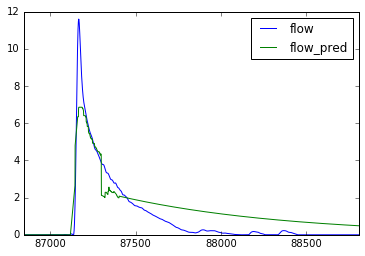

In [65]:
df[df.PWG=='ATS2626.0'][['flow','flow_pred']].plot()

{'boxes': [<matplotlib.lines.Line2D at 0x122429710>],
 'caps': [<matplotlib.lines.Line2D at 0x127456e10>,
 'fliers': [<matplotlib.lines.Line2D at 0x122404f10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1224048d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1224299d0>,
  <matplotlib.lines.Line2D at 0x1200804d0>]}

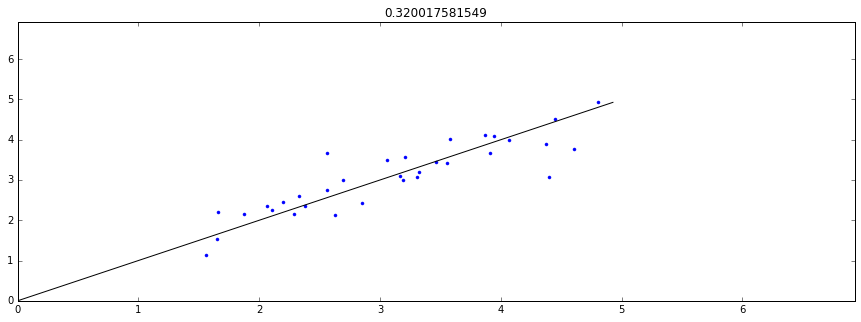

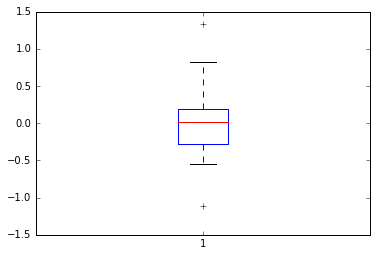

In [66]:
def calc_fev1(f):
    v = np.cumsum(f/float(fs_effective))
    t = np.array(range(len(v)))/float(fs_effective)
    zero_place = [t[np.nanargmax(f)]]
    
    t = t-zero_place[0]
#     plt.plot(t,v)
    t = t[t<=1.0]
    return v[len(t)]

def pd_fev1(grp):
    v1 = calc_fev1(grp['flow'].values)
    v2 = calc_fev1(medfilt(grp['flow_pred'].values,kernel_size=51))
    return pd.DataFrame(np.array([v1,v2]).reshape((1,2)),columns=['fev1','fev1_pred'])

plt.figure(figsize=(15,5))
df_pwg = df.groupby('PWG')
tmp = df_pwg.apply(pd_fev1)

# plt.plot(tmp['fev1'],tmp['fev1_pred'],'.')
# tmp['fev1_pred']= tmp['fev1_pred']-0.5
# plt.title(np.mean(np.abs(tmp['fev1']-tmp['fev1_pred'])))
# plt.xlim([0,2])
# tmp.to_csv('FEV1Results.csv')
tmp['fev1_pred']= tmp['fev1_pred']
plt.plot(tmp['fev1'],tmp['fev1_pred'],'.')


plt.title(np.mean(np.abs(tmp['fev1']-tmp['fev1_pred'])))
mx = max(np.max(tmp['fev1']),np.max(tmp['fev1_pred']))
plt.plot([0,mx],[0,mx],'k')
plt.ylim([0, mx+2])
plt.xlim([0, mx+2])

plt.figure()
plt.boxplot((tmp['fev1']-tmp['fev1_pred']))



{'boxes': [<matplotlib.lines.Line2D at 0x1264d3550>],
 'caps': [<matplotlib.lines.Line2D at 0x1229fd650>,
 'fliers': [<matplotlib.lines.Line2D at 0x11c1e0610>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1229e8d90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x122a08d50>,
  <matplotlib.lines.Line2D at 0x122a08a10>]}

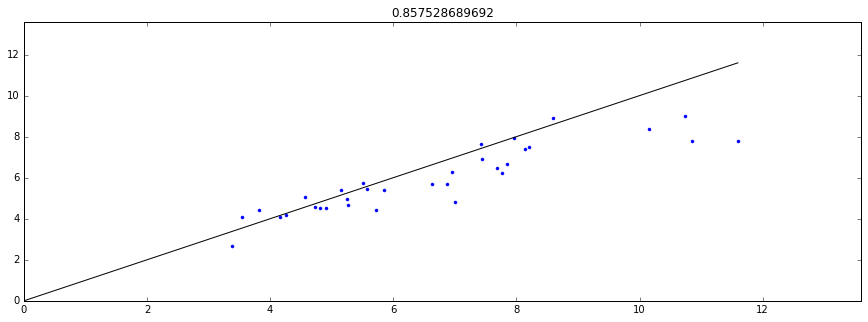

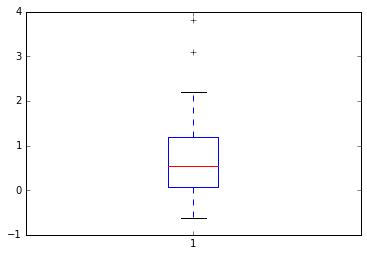

In [67]:
def calc_pef(f):
    return np.max(f)

def pd_pef(grp):
    v1 = calc_pef(grp['flow'].values)
    v2 = calc_pef(medfilt(grp['flow_pred'].values,kernel_size=51))
    return pd.DataFrame(np.array([v1,v2]).reshape((1,2)),columns=['pef','pef_pred'])

plt.figure(figsize=(15,5))
df_pwg = df.groupby('PWG')
tmp = df_pwg.apply(pd_pef)

# plt.plot(tmp['fev1'],tmp['fev1_pred'],'.')
# tmp['fev1_pred']= tmp['fev1_pred']-0.5
# plt.title(np.mean(np.abs(tmp['fev1']-tmp['fev1_pred'])))
# plt.xlim([0,2])
# tmp.to_csv('FEV1Results.csv')
tmp['pef_pred']= tmp['pef_pred']+1
plt.plot(tmp['pef'],tmp['pef_pred'],'.')


plt.title(np.mean(np.abs(tmp['pef']-tmp['pef_pred'])))
mx = max(np.max(tmp['pef']),np.max(tmp['pef_pred']))
plt.plot([0,mx],[0,mx],'k')
plt.ylim([0, mx+2])
plt.xlim([0, mx+2])

plt.figure()
plt.boxplot((tmp['pef']-tmp['pef_pred']))



In [68]:
tmp

,,pef,pef_pred
PWG,,,
ATS24*1.0,0,6.628530,5.711162
ATS24*10.0,0,5.513402,5.728286
ATS24*12.0,0,4.255983,4.174401
ATS24*14.0,0,4.562599,5.076927
ATS24*16.0,0,7.844982,6.675646
ATS24*17.0,0,5.717727,4.414611
ATS24*18.0,0,7.773393,6.245066
ATS24*19.0,0,5.578170,5.424391
ATS24*2.0,0,10.150135,8.383499


{'boxes': [<matplotlib.lines.Line2D at 0x128a75f90>],
 'caps': [<matplotlib.lines.Line2D at 0x128d8aad0>,
 'fliers': [<matplotlib.lines.Line2D at 0x128da0dd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x128da0790>],
 'whiskers': [<matplotlib.lines.Line2D at 0x128ab6a10>,
  <matplotlib.lines.Line2D at 0x128a9a310>]}

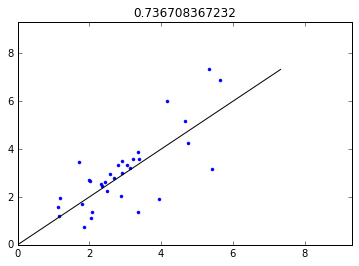

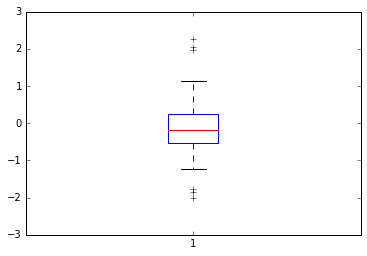

In [69]:
def calc_fef(f):
    v = np.cumsum(f/fs_effective)
    vmax = np.max(v)
    
    return np.mean(f[(v>0.25*vmax)&(v<0.75*vmax)])

def pd_fef(grp):
    v1 = calc_fef(grp['flow'].values)
    v2 = calc_fef(medfilt(grp['flow_pred'].values,kernel_size=51))
    return pd.DataFrame(np.array([v1,v2]).reshape((1,2)),columns=['fef','fef_pred'])

df_pwg = df.groupby('PWG')
tmp = df_pwg.apply(pd_fef)
tmp['fef_pred']= tmp['fef_pred']
plt.plot(tmp['fef'],tmp['fef_pred'],'.')


plt.title(np.mean(np.abs(tmp['fef']-tmp['fef_pred'])))
mx = max(np.max(tmp['fef']),np.max(tmp['fef_pred']))
plt.plot([0,mx],[0,mx],'k')
plt.ylim([0, mx+2])
plt.xlim([0, mx+2])

plt.figure()
plt.boxplot((tmp['fef']-tmp['fef_pred']))
